In [1]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import safetensors
from tqdm import tqdm

In [2]:
from src.datasets import LabeledDataset
from src.models import MLPModel

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
safe = safetensors.safe_open('models/trained_model/model.safetensors', framework='pt', device=0)

In [5]:
state_dict = {key: safe.get_tensor(key) for key in safe.keys()}

In [6]:
model = MLPModel([2048, 1024, 512, 256], nn.PReLU).to(device)
model.load_state_dict(state_dict)
model.eval()

MLPModel(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3360, out_features=2048, bias=True)
    (2): PReLU(num_parameters=1)
    (3): Linear(in_features=2048, out_features=1024, bias=True)
    (4): PReLU(num_parameters=1)
    (5): Linear(in_features=1024, out_features=512, bias=True)
    (6): PReLU(num_parameters=1)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): PReLU(num_parameters=1)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
  (loss_fn): BCEWithLogitsLoss()
)

In [7]:
model

MLPModel(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3360, out_features=2048, bias=True)
    (2): PReLU(num_parameters=1)
    (3): Linear(in_features=2048, out_features=1024, bias=True)
    (4): PReLU(num_parameters=1)
    (5): Linear(in_features=1024, out_features=512, bias=True)
    (6): PReLU(num_parameters=1)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): PReLU(num_parameters=1)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
  (loss_fn): BCEWithLogitsLoss()
)

In [8]:
ds = torch.load('data/dataset.pt', weights_only=False)
ds = LabeledDataset(ds, active_label=1)
generator = torch.Generator().manual_seed(42)
splits = random_split(ds, [.8, .1, .1], generator)
ds = {
    'train': splits[0],
    'dev': splits[1],
    'test': splits[2]
}

In [9]:
dl = DataLoader(ds['test'], batch_size=1024, shuffle=False, pin_memory=True)

In [10]:
y_true = []
y_pred = []

with torch.no_grad():
    for batch in tqdm(dl, desc='Evaluating'):
        y_true.append(batch['labels'])
        X_batch = batch['inputs'].to(device)
        logits = model(X_batch)['logits']
        y_pred.append(nn.functional.sigmoid(logits).cpu())

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
    

Evaluating: 100%|██████████| 4/4 [00:00<00:00,  8.80it/s]


In [11]:
y_pred

tensor([8.7293e-08, 1.0000e+00, 1.0833e-02,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])

In [12]:
roc_auc_score(y_true, y_pred)

np.float64(0.9969943917981048)

[Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'ROC lung cancer Classification')]

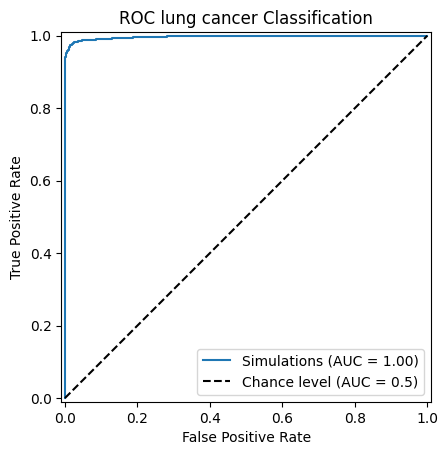

In [13]:
display = RocCurveDisplay.from_predictions(
    y_true,
    y_pred,
    name=f"Simulations",
    plot_chance_level=True,
    # despine=True,
)
display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC lung cancer Classification",
)